In [1]:
# Install SimPy
!pip install simpy

Customer0 arrived at 3.06, waited 0.00 minutes
Customer1 arrived at 3.14, waited 0.00 minutes
Customer0 served in 4.10 minutes, left at 7.16
Customer2 arrived at 3.89, waited 3.27 minutes
Customer1 served in 5.95 minutes, left at 9.08
Customer3 arrived at 7.28, waited 1.80 minutes
Customer3 served in 3.12 minutes, left at 12.20
Customer4 arrived at 7.55, waited 4.65 minutes
Customer2 served in 6.57 minutes, left at 13.73
Customer5 arrived at 9.20, waited 4.53 minutes
Customer5 served in 3.88 minutes, left at 17.61
Customer6 arrived at 9.94, waited 7.67 minutes
Customer4 served in 5.60 minutes, left at 17.80
Customer7 arrived at 12.05, waited 5.75 minutes
Customer7 served in 3.03 minutes, left at 20.83
Customer8 arrived at 12.13, waited 8.70 minutes
Customer6 served in 6.24 minutes, left at 23.85
Customer9 arrived at 12.80, waited 11.05 minutes
Customer8 served in 5.79 minutes, left at 26.62
Customer10 arrived at 15.16, waited 11.46 minutes
Customer9 served in 3.62 minutes, left at 27.4

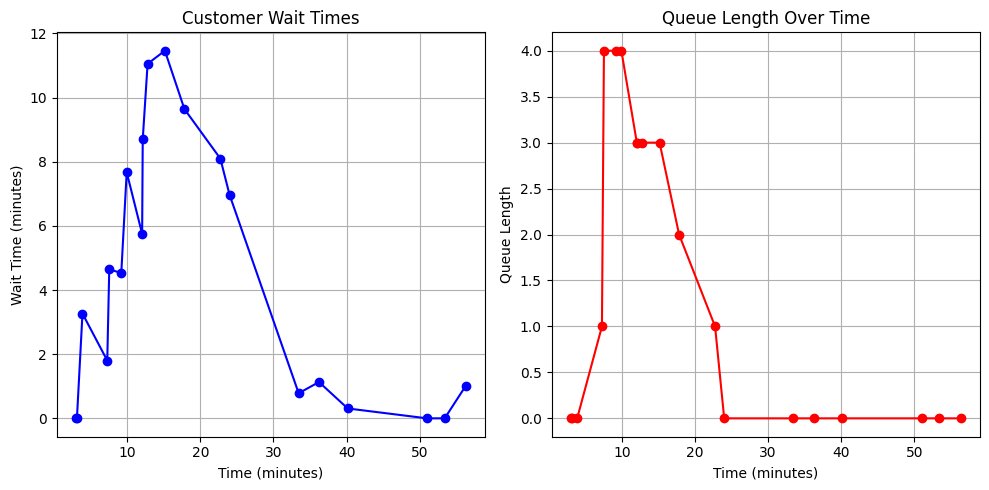

Timestamps: [3.06, 3.14, 3.89, 7.28, 7.55, 9.2, 9.94, 12.05, 12.13, 12.8, 15.16, 17.83, 22.74, 23.99, 33.45, 36.22, 40.15, 51.0, 53.41, 56.3]
Wait Times: [0.0, 0.0, 3.27, 1.8, 4.65, 4.53, 7.67, 5.75, 8.7, 11.05, 11.46, 9.64, 8.1, 6.97, 0.78, 1.13, 0.31, 0.0, 0.0, 1.02]


In [3]:
# Import libraries
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
RANDOM_SEED = 42
SIM_TIME = 60  # Simulate for 60 minutes
NUM_BARISTAS = 2
ARRIVAL_RATE = 1/3  # Customers arrive every ~3 minutes on average
SERVICE_TIME_MIN = 3
SERVICE_TIME_MAX = 7
MAX_CUSTOMERS = 20  # Limit to ensure all customers are processed

# Set random seed for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Data tracking (module-level lists)
wait_times = []
queue_lengths = []
timestamps = []

def customer(env, name, resource):
    """Simulate a customer arriving, waiting, and being served."""
    global timestamps, wait_times, queue_lengths  # Declare global variables
    try:
        arrival_time = env.now
        with resource.request() as req:
            yield req  # Wait for a barista
            # Record data after acquiring resource
            wait_time = env.now - arrival_time
            wait_times.append(wait_time)
            queue_lengths.append(len(resource.queue))
            timestamps.append(arrival_time)
            print(f"{name} arrived at {arrival_time:.2f}, waited {wait_time:.2f} minutes")
            # Simulate service time
            service_time = random.uniform(SERVICE_TIME_MIN, SERVICE_TIME_MAX)
            yield env.timeout(service_time)
            print(f"{name} served in {service_time:.2f} minutes, left at {env.now:.2f}")
    except Exception as e:
        print(f"Error in customer {name}: {e}")

def customer_generator(env, resource, max_customers):
    """Generate a fixed number of customers at random intervals."""
    try:
        customer_id = 0
        while customer_id < max_customers:
            inter_arrival_time = random.expovariate(ARRIVAL_RATE)
            if env.now + inter_arrival_time > SIM_TIME:
                break  # Stop generating if next arrival exceeds SIM_TIME
            yield env.timeout(inter_arrival_time)
            env.process(customer(env, f"Customer{customer_id}", resource))
            customer_id += 1
        print(f"Generated {customer_id} customers")
    except Exception as e:
        print(f"Error in customer_generator: {e}")

def run_simulation():
    """Run the simulation with error handling."""
    try:
        # Validate parameters
        if NUM_BARISTAS < 1:
            raise ValueError("NUM_BARISTAS must be at least 1")
        if SERVICE_TIME_MIN > SERVICE_TIME_MAX:
            raise ValueError("SERVICE_TIME_MIN cannot exceed SERVICE_TIME_MAX")
        if ARRIVAL_RATE <= 0:
            raise ValueError("ARRIVAL_RATE must be positive")
        if SIM_TIME <= 0:
            raise ValueError("SIM_TIME must be positive")

        # Create environment and resource
        env = simpy.Environment()
        barista_resource = simpy.Resource(env, capacity=NUM_BARISTAS)
        env.process(customer_generator(env, barista_resource, MAX_CUSTOMERS))
        env.run(until=SIM_TIME)
        return True
    except Exception as e:
        print(f"Simulation failed: {e}")
        return False

def analyze_and_visualize():
    """Analyze and visualize results with safeguards."""
    global timestamps, wait_times, queue_lengths  # Declare global at the start
    try:
        # Verify data consistency
        lengths = [len(timestamps), len(wait_times), len(queue_lengths)]
        if not lengths[0] == lengths[1] == lengths[2]:
            print(f"Warning: Array length mismatch - timestamps: {lengths[0]}, wait_times: {lengths[1]}, queue_lengths: {lengths[2]}")
            min_length = min(lengths)
            timestamps = timestamps[:min_length]
            wait_times = wait_times[:min_length]
            queue_lengths = queue_lengths[:min_length]
            print(f"Trimmed arrays to length {min_length}")

        # Analyze results
        if wait_times:
            avg_wait_time = np.mean(wait_times)
            max_wait_time = np.max(wait_times)
            avg_queue_length = np.mean(queue_lengths)
            print(f"Average wait time: {avg_wait_time:.2f} minutes")
            print(f"Maximum wait time: {max_wait_time:.2f} minutes")
            print(f"Average queue length: {avg_queue_length:.2f} customers")
        else:
            print("No customers processed. Check simulation parameters.")
            return

        # Visualize with matplotlib
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(timestamps, wait_times, marker='o', color='b')
        plt.xlabel('Time (minutes)')
        plt.ylabel('Wait Time (minutes)')
        plt.title('Customer Wait Times')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(timestamps, queue_lengths, marker='o', color='r')
        plt.xlabel('Time (minutes)')
        plt.ylabel('Queue Length')
        plt.title('Queue Length Over Time')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Print data for Chart.js (optional)
        print("Timestamps:", [round(t, 2) for t in timestamps])
        print("Wait Times:", [round(w, 2) for w in wait_times])
    except Exception as e:
        print(f"Visualization failed: {e}")

# Run the simulation and visualize results
if run_simulation():
    analyze_and_visualize()
else:
    print("Cannot visualize due to simulation failure.")